In [21]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve, GridSearchCV
from sklearn.metrics import accuracy_score
import seaborn as sns
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import pandas as pd
import matplotlib.pyplot as plt

# **Task # 01**

## **Exercise Questions:**

In [ ]:
mnist = fetch_openml('mnist_784', as_frame=False)   # Load dataset from library

In [ ]:
X,y = mnist.data, mnist.target    # Storing Data and Target into X and y

In [ ]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
X = X/255.0 # Normalization of Data

In [ ]:
X.shape # Checking rows and columns

(70000, 784)

In [ ]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [ ]:
y.shape

(70000,)

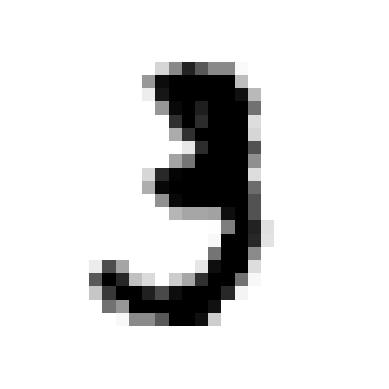

In [ ]:
# Plot the images using matplot

import matplotlib.pyplot as plt
def plot_digit(image_data):
  image = image_data.reshape(28, 28)
  plt.imshow(image, cmap="binary")
  plt.axis("off")
some_digit = X[10]
plot_digit(some_digit)
plt.show()



### **Question: 01**

In [ ]:
# Train the KNN Classifier according to excercise question

knn_clf = KNeighborsClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {
    'n_neighbors': [3, 4, 5],
    'weights': ['uniform', 'distance']
}

# Grid search with 3-fold cross-validation

randsrc_knn = RandomizedSearchCV(knn_clf, param_distributions=param_grid, n_iter=6 ,cv=5, n_jobs=-1, verbose=1)
randsrc_knn.fit(X_train, y_train)

# Best estimator
best_knn = randsrc_knn.best_estimator_

# Evaluate on test set
y_pred = best_knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
print("Best Parameters:", randsrc_knn.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Test Accuracy: 0.9715714285714285
Best Parameters: {'weights': 'distance', 'n_neighbors': 4}


In [ ]:
knn_clf = KNeighborsClassifier(
    n_neighbors=randsrc_knn.best_params_["n_neighbors"],
    weights=randsrc_knn.best_params_["weights"]
)
knn_clf.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=4, weights='distance')

In [ ]:
knn_clf.predict([some_digit])

array(['3'], dtype=object)

### **Question: 02 (Data Argumentation)**

In [ ]:
def shift_image(image, direction):
    image = image.reshape(28, 28)
    shifted = np.zeros_like(image)

    if direction == 'up':
        shifted[:-1, :] = image[1:, :]
    elif direction == 'down':
        shifted[1:, :] = image[:-1, :]
    elif direction == 'left':
        shifted[:, :-1] = image[:, 1:]
    elif direction == 'right':
        shifted[:, 1:] = image[:, :-1]
    else:
        raise ValueError("Direction must be 'up', 'down', 'left', or 'right'.")

    return shifted.flatten()

def augment_dataset(X, y):
    directions = ['up', 'down', 'left', 'right']
    X_augmented = []
    y_augmented = []

    for image, label in zip(X, y):
        for direction in directions:
            shifted_image = shift_image(image, direction)
            X_augmented.append(shifted_image)
            y_augmented.append(label)

    X_augmented = np.array(X_augmented)
    y_augmented = np.array(y_augmented)

    # Combine original and augmented data
    X_full = np.concatenate([X, X_augmented], axis=0)
    y_full = np.concatenate([y, y_augmented], axis=0)

    return X_full, y_full

# Example usage with CuPy arrays
X_train = np.array(X_train)  # Convert your data to CuPy arrays
y_train = np.array(y_train)

X_train_aug, y_train_aug = augment_dataset(X_train, y_train)
print("Original:", X_train.shape)
print("Augmented:", X_train_aug.shape)

Original: (60000, 784)
Augmented: (300000, 784)


In [ ]:
new_knn_clf = KNeighborsClassifier(n_neighbors=randsrc_knn.best_params_["n_neighbors"], weights=randsrc_knn.best_params_["weights"])

# Evaluate the model using cross-validation on the augmented training set
scores = cross_val_score(knn_clf, X_train_aug, y_train_aug, cv=3, scoring='accuracy')

# Output the results
print("Cross-validation accuracies:", scores)
print("Mean accuracy:", scores.mean())

# As we can see our model, is still predicting
# the accuracy upto 98% after shifting
# the pixel of an image.

Cross-validation accuracies: [0.98459598 0.98106947 0.97977126]
Mean accuracy: 0.9818122365674565


### **Question: 03 (Titanic Dataset)**

In [ ]:
df = sns.load_dataset("titanic")
df.head(5)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [ ]:
df.isnull().sum()

,0
survived,0
pclass,0
sex,0
age,177
sibsp,0
parch,0
fare,0
embarked,2
class,0
who,0


In [ ]:
df.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Simple imputer is a library which
# helps you to remove null-values easily
from sklearn.impute import SimpleImputer

X_train, X_test, y_train, y_test = train_test_split(df.drop('survived', axis=1), df['survived'], test_size=0.3, random_state=42)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, ['age', 'fare']),
    ('cat', cat_pipeline, ['sex', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alone']),
])
full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['age', 'fare']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['sex', 'embarked', 'class', 'who',
                                  'adult_male', 'deck', 'embark_town',
                                  'alone'])])

In [ ]:
X_train_prep = full_pipeline.fit_transform(X_train)
X_test_prep = full_pipeline.transform(X_test)

In [ ]:
X_train_prep,X_test_prep

(array([[  4.    ,  81.8583,   0.    , ...,   1.    ,   1.    ,   0.    ],
        [ 28.    ,   7.8958,   0.    , ...,   1.    ,   0.    ,   1.    ],
        [  1.    ,  11.1333,   1.    , ...,   1.    ,   1.    ,   0.    ],
        ...,
        [ 41.    ,  14.1083,   0.    , ...,   1.    ,   1.    ,   0.    ],
        [ 14.    , 120.    ,   1.    , ...,   1.    ,   1.    ,   0.    ],
        [ 21.    ,  77.2875,   0.    , ...,   1.    ,   1.    ,   0.    ]]),
 array([[28.    , 15.2458,  0.    , ...,  0.    ,  1.    ,  0.    ],
        [31.    , 10.5   ,  0.    , ...,  1.    ,  0.    ,  1.    ],
        [20.    ,  7.925 ,  0.    , ...,  1.    ,  0.    ,  1.    ],
        ...,
        [65.    , 26.55  ,  0.    , ...,  1.    ,  0.    ,  1.    ],
        [17.    ,  8.6625,  0.    , ...,  1.    ,  0.    ,  1.    ],
        [28.    , 26.55  ,  0.    , ...,  1.    ,  0.    ,  1.    ]]))

In [ ]:
tree = DecisionTreeClassifier()
param_distributions = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Total combinations = 4 × 3 × 3 = 36

tree_grid = RandomizedSearchCV(
    estimator=tree,
    param_distributions=param_distributions,
    n_iter=20,  # Optional: <= 36
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

tree_grid.fit(X_train_prep, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [None, 5, 10, 15],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   verbose=1)

In [ ]:
tree_grid.best_params_

{'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10}

In [ ]:
tree = DecisionTreeClassifier(
    max_depth=tree_grid.best_params_["max_depth"],
    min_samples_leaf=tree_grid.best_params_["min_samples_leaf"],
    min_samples_split=tree_grid.best_params_["min_samples_split"]
)
tree.fit(X_train_prep, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=5)

In [ ]:
print(f'Accuracy: {cross_val_score(tree, X_train_prep, y_train, cv=10, scoring="accuracy").mean()}')

Accuracy: 0.8122375832053251


### **Question: 04**

## **Comparisons:**

<html>
<h2>SGD Classifier vs Random Forest</h2>
<table border="1" cellpadding="8" cellspacing="0">
  <thead>
    <tr>
      <th>Aspect</th>
      <th>SGD Classifier</th>
      <th>Random Forest</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>How it works</td>
      <td>It learns a straight-line (or plane) decision boundary by adjusting weights using gradient descent.</td>
      <td>It builds many decision trees and combines their results — like asking multiple people and taking a vote.</td>
    </tr>
    <tr>
      <td>Training time</td>
      <td>Very quick, especially on large datasets — just one model being trained in small steps.</td>
      <td>Slower, because it builds lots of trees — but still fast thanks to parallel processing.</td>
    </tr>
    <tr>
      <td>Best for</td>
      <td>Problems where the data is mostly linear and speed matters.</td>
      <td>When you care more about accuracy and the data has complex patterns.</td>
    </tr>
    <tr>
      <td>Can it handle complex data?</td>
      <td>Not really — unless you engineer new features, it might miss non-linear trends.</td>
      <td>Yes — trees naturally split based on what the data needs.</td>
    </tr>
    <tr>
      <td>Overfitting</td>
      <td>Low risk if you tune the regularization properly.</td>
      <td>Lower risk because the forest averages multiple trees to balance noise.</td>
    </tr>
    <tr>
      <td>Online learning</td>
      <td>Yes! It can learn in small batches, great for streaming data.</td>
      <td>No — it needs all data before training begins.</td>
    </tr>
  </tbody>
</table>
<h2>One-vs-Rest (OvR) vs One-vs-One (OvO)</h2>
<table border="1" cellpadding="8" cellspacing="0">
  <thead>
    <tr>
      <th>Aspect</th>
      <th>One-vs-Rest (OvR)</th>
      <th>One-vs-One (OvO)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Basic idea</td>
      <td>Trains one classifier per class, trying to separate it from all the others.</td>
      <td>Builds a separate classifier for every possible pair of classes.</td>
    </tr>
    <tr>
      <td>Number of classifiers</td>
      <td>Equal to the number of classes (e.g., 10 classes = 10 models).</td>
      <td>More models — one for each class pair (10 classes = 45 models).</td>
    </tr>
    <tr>
      <td>Training time</td>
      <td>Generally faster because fewer models are trained.</td>
      <td>Takes longer due to the large number of models.</td>
    </tr>
    <tr>
      <td>Prediction time</td>
      <td>Quick — just evaluate n classifiers.</td>
      <td>Slower — combines votes from all pairs.</td>
    </tr>
    <tr>
      <td>When to use</td>
      <td>Good for large datasets or when using linear classifiers like Logistic Regression or SGD.</td>
      <td>Better for smaller datasets or non-linear models like SVMs.</td>
    </tr>
    <tr>
      <td>Which is easier?</td>
      <td>Simpler to understand and implement.</td>
      <td>More complex due to many combinations, but can perform better in some cases.</td>
    </tr>
  </tbody>
</table>

</html>

## **2) MNIST Dataset**

In [ ]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    """Reshapes and displays a single MNIST digit image."""
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# Fetch the MNIST dataset
mnist = fetch_openml('mnist_784', as_frame=False)
X, y = mnist.data, mnist.target

# Plot a single digit (the first image in the dataset)
some_digit = X[10]
plot_digit(some_digit)
plt.show()

# Plot a grid of 100 digits
plt.figure(figsize=(28, 28))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=10000, random_state=42)

#### **Stohastic Gradient Descent Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

In [ ]:
sgd_clf = SGDClassifier(random_state=42, loss='hinge')

param_grid = {
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [1000, 2000, 3000],
}
# We also use other CV technique like (Kfolds, Startified, 1-out etc)
grid_sgd = RandomizedSearchCV(sgd_clf, param_distributions=param_grid, n_iter=9,cv=3, n_jobs=-1, verbose=1)
grid_sgd.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


RandomizedSearchCV(cv=3, estimator=SGDClassifier(random_state=42), n_iter=9,
                   n_jobs=-1,
                   param_distributions={'alpha': [0.0001, 0.001, 0.01],
                                        'max_iter': [1000, 2000, 3000]},
                   verbose=1)

In [ ]:
grid_sgd.best_params_

{'max_iter': 1000, 'alpha': 0.0001}

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
sgd_clf = SGDClassifier(
    alpha=grid_sgd.best_params_["alpha"],
    max_iter=grid_sgd.best_params_["max_iter"],
)
sgd_clf.fit(X_train, y_train)
sgd_pred = grid_sgd.predict(X_test)

print(f"Accuracy: {cross_val_score(sgd_clf, X_train, y_train, cv=10, scoring='accuracy').mean()}")

Accuracy: 0.8723166666666667


In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, sgd_pred))

print("\nClassification Report:")
print(classification_report(y_test, sgd_pred))

Confusion Matrix:
[[ 933    0    4    1    1   19   10    2   12    1]
 [   0 1124    1    5    1    9    1    0   10    1]
 [  14   16  694   82   15   36   21    9   78    2]
 [   2    5    5  822    3  138    4    4   36   15]
 [   3    4    3    1  841    9    7    3   14   21]
 [   5    5    2   15   11  862    5    2   28    2]
 [   2    4    4    2    5   54  867    0   23    0]
 [   5    5    7    7   19   15    0  943   20   34]
 [   8   19    0   17    4  135    3    5  771    7]
 [   9    6    1    7   71   35    0   37   36  834]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       983
           1       0.95      0.98      0.96      1152
           2       0.96      0.72      0.82       967
           3       0.86      0.79      0.82      1034
           4       0.87      0.93      0.90       906
           5       0.66      0.92      0.77       937
           6       0.94      0.90      0.92     

#### **Random Forest Classifier**

In [ ]:
rfc = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}
grid_rfc = RandomizedSearchCV(rfc, param_distributions=param_grid, n_iter=18,cv=3, n_jobs=-1, verbose=1)
grid_rfc.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=18, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   verbose=1)

In [ ]:
grid_rfc.best_params_

{'n_estimators': 200, 'min_samples_split': 2, 'max_depth': None}

In [ ]:
rfc = RandomForestClassifier(
    n_estimators=grid_rfc.best_params_["n_estimators"],
    max_depth=grid_rfc.best_params_["max_depth"],
    min_samples_split=grid_rfc.best_params_["min_samples_split"])

rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

print(f"Accuracy: {cross_val_score(rfc, X_train, y_train, cv=5, scoring='accuracy').mean()}")

Accuracy: 0.9687666666666667


In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, rfc_pred))

print("\nClassification Report:")
print(classification_report(y_test, rfc_pred))

Confusion Matrix:
[[ 967    0    4    1    1    1    2    1    6    0]
 [   0 1136    5    5    1    0    0    2    2    1]
 [   2    1  942    2    4    0    4    4    7    1]
 [   1    0   18  983    0    8    0    9    8    7]
 [   3    1    1    0  874    0    5    3    2   17]
 [   0    1    3   10    3  904    6    1    8    1]
 [   2    1    0    0    2    8  947    0    1    0]
 [   1    5   15    0    5    0    0 1020    1    8]
 [   0    4    7   11    4    7    3    7  920    6]
 [   4    4    2   12   14    1    1    8    9  981]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       983
           1       0.99      0.99      0.99      1152
           2       0.94      0.97      0.96       967
           3       0.96      0.95      0.96      1034
           4       0.96      0.96      0.96       906
           5       0.97      0.96      0.97       937
           6       0.98      0.99      0.98     

In [ ]:
y_probs = rfc.predict_proba(X_test)

misclassified_idxs = np.where(rfc_pred != y_test)[0]

# Convert true labels and predicted labels to arrays
y_test_array = np.array(y_test)
# Map predicted labels to class indices
predicted_labels = rfc_pred[misclassified_idxs]
class_indices = np.array([np.where(rfc.classes_ == label)[0][0] for label in predicted_labels])

# Get confidence scores of wrong predictions
confidences = y_probs[misclassified_idxs, class_indices]

# Sort most confident wrong predictions
worst_idxs = misclassified_idxs[np.argsort(-confidences)]

In [ ]:
import joblib

joblib.dump(rfc, 'rfc_model.pkl')

['rfc_model.pkl']

In [ ]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.6 MB/s eta 0:00:00


In [ ]:
import gradio as gr
import numpy as np
from PIL import Image

In [ ]:
# Load your trained RFC model
model = joblib.load("rfc_model.pkl")  # change filename as needed

def preprocess_image(image: Image.Image):
    image = image.convert("L")  # convert to grayscale
    image = image.resize((28, 28))  # ensure it's 28x28
    image_array = np.array(image).astype(np.uint8)
    flattened = image_array.flatten().reshape(1, -1)  # shape (1, 784)
    return flattened

def predict_digit(image):
    input_array = preprocess_image(image)
    prediction = model.predict(input_array)
    return f"Predicted Digit: {prediction[0]}"

interface = gr.Interface(
    fn=predict_digit,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="RFC Digit Classifier",
    description="Upload a 28x28 grayscale image to classify a digit using Random Forest."
)

if __name__ == "__main__":
    interface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://13643c914eefc83049.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


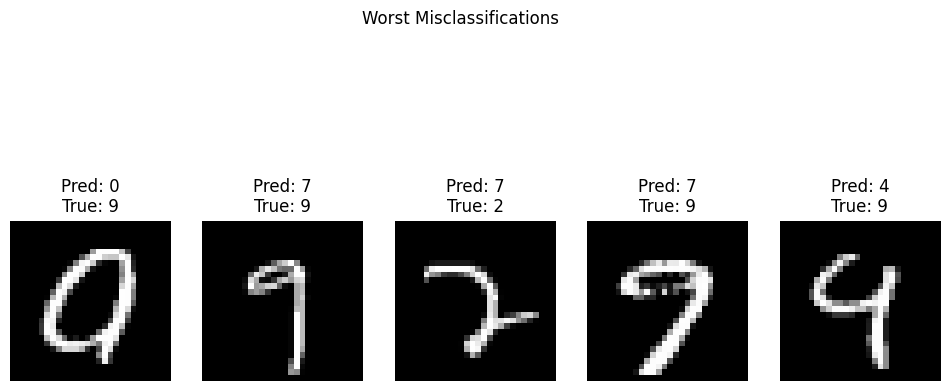

In [ ]:
import matplotlib.pyplot as plt

# Replace 'X_test' indexing below appropriately for your data type
plt.figure(figsize=(12, 6))
for i, idx in enumerate(worst_idxs[:5]):  # Top 5 worst
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')  # Adjust shape as needed
    plt.title(f"Pred: {rfc_pred[idx]}\nTrue: {y_test[idx]}")
    plt.axis('off')
plt.suptitle('Worst Misclassifications')
plt.show()


## **Error Analysis Report**

- As you can see the false predicted values in the above figure.
  - First image, represents 9 -> 0 because of huge circle like 0.
  - Second 3 -> 2, because irregularly written 3 seems like it is 2.
  - Thirdly, 2 -> 7 even a human can confuse is it 7 or 2.

## **Solutions**

- Data Augmentation: Rotate, scale, or distort digits to teach the model invariance to handwriting variations.
- More Training Data: Add more labeled examples, especially for confusing classes.
- Model Improvements:
  - Use a deeper or better-tuned CNN.
  - Add dropout or batch normalization.
- Hyperparameter Tuning

## **Solution Implementation**

In [ ]:
def shift_image(image, direction):
    image = image.reshape(28, 28)
    shifted = np.zeros_like(image)

    if direction == 'up':
        shifted[:-1, :] = image[1:, :]
    elif direction == 'down':
        shifted[1:, :] = image[:-1, :]
    elif direction == 'left':
        shifted[:, :-1] = image[:, 1:]
    elif direction == 'right':
        shifted[:, 1:] = image[:, :-1]
    else:
        raise ValueError("Direction must be 'up', 'down', 'left', or 'right'.")

    return shifted.flatten()

def augment_dataset(X, y):
    directions = ['up', 'down', 'left', 'right']
    X_augmented = []
    y_augmented = []

    for image, label in zip(X, y):
        for direction in directions:
            shifted_image = shift_image(image, direction)
            X_augmented.append(shifted_image)
            y_augmented.append(label)

    X_augmented = np.array(X_augmented)
    y_augmented = np.array(y_augmented)

    # Combine original and augmented data
    X_full = np.concatenate([X, X_augmented], axis=0)
    y_full = np.concatenate([y, y_augmented], axis=0)

    return X_full, y_full

# Example usage with CuPy arrays
X_train = np.array(X_train)  # Convert your data to CuPy arrays
y_train = np.array(y_train)

X_train_aug, y_train_aug = augment_dataset(X_train, y_train)
print("Original:", X_train.shape)
print("Augmented:", X_train_aug.shape)

Original: (60000, 784)
Augmented: (300000, 784)


In [ ]:
rfc = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2)

rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

print(f"Accuracy: {cross_val_score(rfc, X_train, y_train, cv=5, scoring='accuracy').mean()}")

Accuracy: 0.9685833333333334


In [ ]:
import joblib
joblib.dump(rfc, 'final_rfc_model.pkl')

['final_rfc_model.pkl']

In [ ]:
# Load your trained RFC model
model = joblib.load("final_rfc_model.pkl")  # change filename as needed

def preprocess_image(image: Image.Image):
    image = image.convert("L")  # convert to grayscale
    image = image.resize((28, 28))  # ensure it's 28x28
    image_array = np.array(image).astype(np.uint8)
    flattened = image_array.flatten().reshape(1, -1)  # shape (1, 784)
    return flattened

def predict_digit(image):
    input_array = preprocess_image(image)
    prediction = model.predict(input_array)
    return f"Predicted Digit: {prediction[0]}"

interface = gr.Interface(
    fn=predict_digit,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="RFC Digit Classifier",
    description="Upload a 28x28 grayscale image to classify a digit using Random Forest."
)

if __name__ == "__main__":
    interface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://eb4411676af4588fc8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


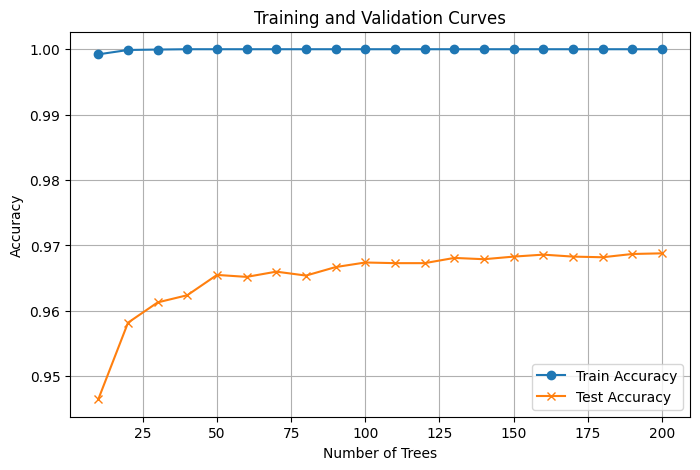

In [ ]:
from sklearn.metrics import accuracy_score

n_estimators_list = list(range(10, 201, 10))  # Vary number of trees from 10 to 200
train_accuracies = []
test_accuracies = []

for n in n_estimators_list:
    rfc = RandomForestClassifier(n_estimators=n, max_depth=None, min_samples_split=2, random_state=42)
    rfc.fit(X_train, y_train)

    train_acc = accuracy_score(y_train, rfc.predict(X_train))
    test_acc = accuracy_score(y_test, rfc.predict(X_test))

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(n_estimators_list, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(n_estimators_list, test_accuracies, label='Test Accuracy', marker='x')
plt.title('Training and Validation Curves')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()


# **Task # 02**

## **Excercise Question**

### **1. Use Stochastic Gradient Descent (SGD) or Mini-batch Gradient Descent—they handle large feature sets efficiently.**

### **2. Algorithms that suffer from features with different scales:**
- Gradient Descent (slow convergence)
- SVMs (biased hyperplanes)
- k-NN, PCA, Logistic Regression
### **Fix: Use feature scaling (e.g., Standardization or Min-Max Scaling).**

### **3. No. Logistic Regression cost function is convex ⇒ Gradient Descent won’t get stuck in a local minimum.**

### **4. No. Different Gradient Descent variants may converge to slightly different points due to:**

- Learning rate
- Stochasticity (in SGD/Mini-batch)
- Early stopping

### **5. Likely cause: Overfitting or too high learning rate.**
Fix:
- Use early stopping
- Reduce learning rate
- Add regularization

### **6. No. Mini-batch GD fluctuates naturally. Use early stopping with patience instead of stopping immediately.**

### **7. Which Gradient Descent algorithm (among those we discussed) will reach the vicinity of the optimal solution the fastest?**

- Fastest to reach vicinity: Stochastic Gradient Descent
- Converges smoothly: Batch Gradient Descent
#### **To make others converge:**
- Decay the learning rate over time

### **8. Large training-validation gap ⇒ Overfitting (high variance)**

## Solutions:
- Reduce model complexity
- Add regularization (Ridge/Lasso)
- Increase training data

### **9.** High training + validation error, nearly equal ⇒ High bias
Solution: Reduce α to decrease regularization and allow model to fit better.

### **10. Why use:**

- Ridge Regression: Prevents overfitting (shrinks coefficients, especially useful in multicollinearity).
- Lasso: Performs feature selection (drives some weights to 0).
- Elastic Net: Combines benefits of Ridge and Lasso; works well when features are correlated.

### **11.** Use two binary Logistic Regression classifiers, not Softmax (multi-class). These are two independent binary classification tasks.

In [ ]:
# Load and prepare data
iris = load_iris()
X = iris.data
y = iris.target.reshape(-1, 1)

# One-hot encode labels
encoder = OneHotEncoder(sparse_output = False)
y_encoded = encoder.fit_transform(y)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Initialize
n_features = X_train.shape[1]
n_classes = y_encoded.shape[1]
W = np.zeros((n_features, n_classes))
b = np.zeros((1, n_classes))
learning_rate = 0.1
n_epochs = 1000
tolerance = 1e-4
patience = 10

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def compute_loss(X, y, W, b):
    m = X.shape[0]
    logits = np.dot(X, W) + b
    probs = softmax(logits)
    return -np.mean(np.sum(y * np.log(probs + 1e-9), axis=1))

# Training with early stopping
best_loss = float('inf')
wait = 0

for epoch in range(n_epochs):
    logits = np.dot(X_train, W) + b
    probs = softmax(logits)

    # Gradients
    error = probs - y_train
    dW = np.dot(X_train.T, error) / X_train.shape[0]
    db = np.mean(error, axis=0, keepdims=True)

    # Update
    W -= learning_rate * dW
    b -= learning_rate * db

    # Validation loss
    val_loss = compute_loss(X_val, y_val, W, b)

    if val_loss < best_loss - tolerance:
        best_loss = val_loss
        best_W, best_b = W.copy(), b.copy()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

print("Training complete. Final validation loss:", best_loss)


Training complete. Final validation loss: 0.10039905887907061


## **Task Codes**

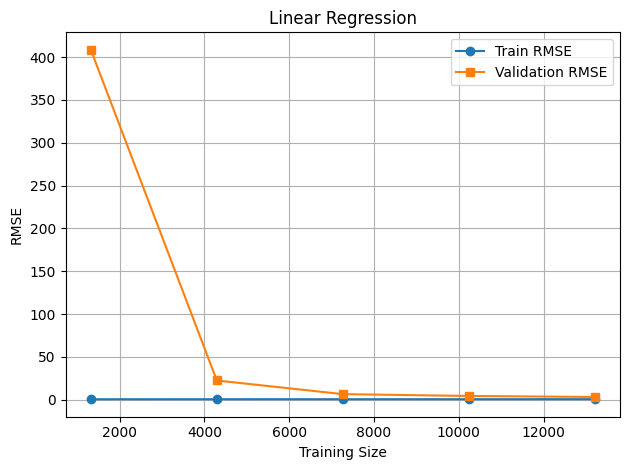

Linear Regression RMSE: 0.4643015238301055
Best SGD: {'sgd__alpha': 0.01, 'sgd__eta0': 0.01, 'sgd__learning_rate': 'constant', 'sgd__penalty': 'l2'}


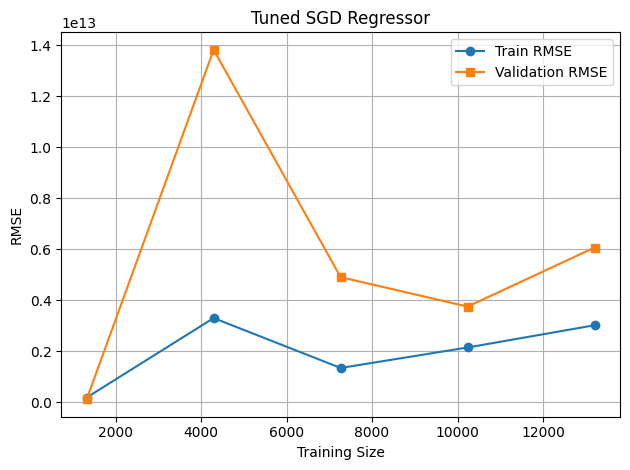

Best Ridge: {'ridge__alpha': 1}


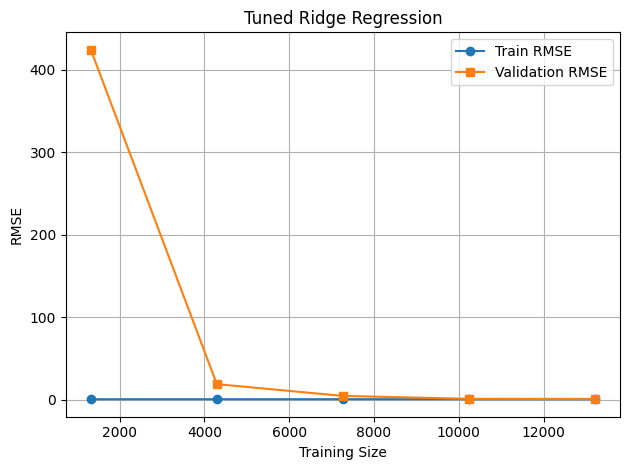

Best Lasso: {'lasso__alpha': 0.01}


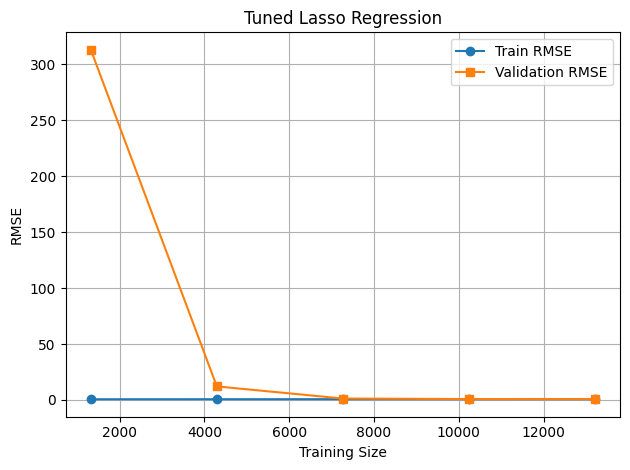

Best Logistic Regression: {'logreg__C': 10}
Logistic Regression Accuracy: 0.8611918604651163


In [23]:
from sklearn.datasets import fetch_california_housing
import time

train_times = {}
# Load dataset
data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Binary classification target for Logistic Regression
y_class = (y > y.mean()).astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
_, _, y_class_train, y_class_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)

# Function to plot learning curves
def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, scoring='neg_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
    )
    train_rmse = (-train_scores.mean(axis=1))**0.5
    val_rmse = (-val_scores.mean(axis=1))**0.5

    plt.figure()
    plt.plot(train_sizes, train_rmse, 'o-', label="Train RMSE")
    plt.plot(train_sizes, val_rmse, 's-', label="Validation RMSE")
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Common pipeline steps
preprocess = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("poly", poly),
    ("scaler", StandardScaler())
])

X_train_proc = preprocess.fit_transform(X_train)
X_test_proc = preprocess.transform(X_test)

# ----------------------------
# (c1) Linear Regression
# ----------------------------
lin_reg = LinearRegression()
start = time.time()
lin_reg.fit(X_train_proc, y_train)
end = time.time()
train_times["Linear Regression"] = end - start
plot_learning_curve(Pipeline([("model", lin_reg)]), X_train_proc, y_train, "Linear Regression")
print("Linear Regression RMSE:", mean_squared_error(y_test, lin_reg.predict(X_test_proc)))

# ----------------------------
# (c2) SGD Regressor (with GridSearch)
# ----------------------------
sgd_pipe = Pipeline([
    ("prep", preprocess),
    ("sgd", SGDRegressor(max_iter=1000, tol=1e-3, random_state=42))
])
param_sgd = {
    "sgd__alpha": [0.0001, 0.001, 0.01],
    "sgd__penalty": ["l2", "l1"],
    "sgd__eta0": [0.01, 0.1],
    "sgd__learning_rate": ["constant"]
}
grid_sgd = GridSearchCV(sgd_pipe, param_sgd, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_sgd.fit(X_train, y_train)
print("Best SGD:", grid_sgd.best_params_)
plot_learning_curve(grid_sgd.best_estimator_, X_train, y_train, "Tuned SGD Regressor")

# ----------------------------
# (c3) Ridge Regression
# ----------------------------
ridge_pipe = Pipeline([
    ("prep", preprocess),
    ("ridge", Ridge())
])
param_ridge = {"ridge__alpha": [0.01, 0.1, 1, 10, 100]}
grid_ridge = GridSearchCV(ridge_pipe, param_ridge, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_ridge.fit(X_train, y_train)
print("Best Ridge:", grid_ridge.best_params_)
plot_learning_curve(grid_ridge.best_estimator_, X_train, y_train, "Tuned Ridge Regression")

# ----------------------------
# (c4) Lasso Regression
# ----------------------------
lasso_pipe = Pipeline([
    ("prep", preprocess),
    ("lasso", Lasso(max_iter=5000))
])
param_lasso = {"lasso__alpha": [0.0001, 0.001, 0.01, 0.1]}
grid_lasso = GridSearchCV(lasso_pipe, param_lasso, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_lasso.fit(X_train, y_train)
print("Best Lasso:", grid_lasso.best_params_)
plot_learning_curve(grid_lasso.best_estimator_, X_train, y_train, "Tuned Lasso Regression")

# ----------------------------
# (c5) Logistic Regression (classification)
# ----------------------------
logreg_pipe = Pipeline([
    ("prep", preprocess),
    ("logreg", LogisticRegression(max_iter=1000))
])
param_log = {"logreg__C": [0.01, 0.1, 1, 10]}
grid_log = GridSearchCV(logreg_pipe, param_log, cv=5, scoring="accuracy", n_jobs=-1)
grid_log.fit(X_train, y_class_train)
print("Best Logistic Regression:", grid_log.best_params_)
y_class_pred = grid_log.predict(X_test)
acc = accuracy_score(y_class_test, y_class_pred)
print("Logistic Regression Accuracy:", acc)


In [43]:
sgd = SGDRegressor(alpha=0.0001, eta0=0.01, learning_rate='constant', max_iter=1000,
             random_state=42, tol=0.001)

start = time.time()
sgd.fit(X_train_proc, y_train)
end = time.time()
train_times["SGD"] = end - start
print("SGD RMSE:", mean_squared_error(y_test, sgd.predict(X_test_proc)))

SGD RMSE: 1.4720382636036363e+24


In [44]:
ridge = Ridge(alpha=100)
start = time.time()
ridge.fit(X_train_proc, y_train)
end = time.time()
train_times["Ridge"] = end - start
print("Ridge RMSE:", mean_squared_error(y_test, ridge.predict(X_test_proc)))

Ridge RMSE: 0.5088507930468369


In [45]:
lasso = Lasso(alpha=0.0001, max_iter=5000)
start = time.time()
lasso.fit(X_train_proc, y_train)
end = time.time()
train_times["Lasso"] = end - start
print("Lasso RMSE:", mean_squared_error(y_test, lasso.predict(X_test_proc)))

Lasso RMSE: 0.47064863093338355


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.627e+03, tolerance: 2.207e+00
  model = cd_fast.enet_coordinate_descent(


In [49]:
logreg = LogisticRegression(C=10)
start = time.time()
logreg.fit(X_train_proc, y_class_train)
end = time.time()
train_times["Logistic Regression"] = end - start

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [50]:
from sklearn.metrics import f1_score, r2_score

# --- REGRESSION METRICS ---
print("\n--- Regression Model Performance on Test Set ---\n")

# Linear Regression
y_pred_lin = lin_reg.predict(X_test_proc)
print("Linear Regression → RMSE:", mean_squared_error(y_test, y_pred_lin),
      " | R²:", r2_score(y_test, y_pred_lin))

# SGD Regressor
y_pred_sgd = grid_sgd.predict(X_test)
print("SGD Regressor     → RMSE:", (mean_squared_error(y_test, y_pred_sgd)),
      "  | R²:", r2_score(y_test, y_pred_sgd))

# Ridge
y_pred_ridge = grid_ridge.predict(X_test)
print("Ridge Regression  → RMSE:", mean_squared_error(y_test, y_pred_ridge),
      " | R²:", r2_score(y_test, y_pred_ridge))

# Lass
y_pred_lasso = grid_lasso.predict(X_test)
print("Lasso Regression  → RMSE:", mean_squared_error(y_test, y_pred_lasso),
      "  | R²:", r2_score(y_test, y_pred_lasso))

# --- CLASSIFICATION METRICS ---
print("\n--- Classification Model Performance on Test Set ---")
f1 = f1_score(y_class_test, y_class_pred)
print("Logistic Regression → Accuracy:", acc, " | F1-score:", f1)



--- Regression Model Performance on Test Set ---

Linear Regression → RMSE: 0.4643015238301055  | R²: 0.6456819729262031
SGD Regressor     → RMSE: 7.853263873298747e+22   | R²: -5.992986925227735e+22
Ridge Regression  → RMSE: 0.47288331755005314  | R²: 0.6391330299149398
Lasso Regression  → RMSE: 0.5614805294027077   | R²: 0.5715226782432137

--- Classification Model Performance on Test Set ---
Logistic Regression → Accuracy: 0.8611918604651163  | F1-score: 0.8241791960724149


In [51]:
train_times

{'Linear Regression': 0.0846703052520752,
 'SGD Regressor': 0.15411877632141113,
 'Ridge': 0.4256458282470703,
 'Lasso': 9.17860198020935,
 'Logistic Regression': 2.4203765392303467,
 'SGD': 0.05415058135986328}